In [1]:
import json
import os
from os import path
from tqdm import tqdm
from tld import get_fld
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display_markdown

def printMD(txt):
    display_markdown(txt, raw=True)


In [2]:
DATA_PATH = "/mnt/data/MT/pilot-crawl3"

def isCrawlDataFile(filename: str):
    return filename.endswith(".json") and filename != "metadata.json" and path.isfile(path.join(DATA_PATH, filename))

json_files = [f for f in os.listdir(DATA_PATH) if isCrawlDataFile(f)]
print("Found %d JSON files" % len(json_files))

Found 683 JSON files


In [3]:
all_sites = []
all_calls = []

for filename in tqdm(json_files):
    with open(path.join(DATA_PATH, filename)) as file:
        crawl_data = json.load(file)
        initial_url = crawl_data["initialUrl"]
        final_url = crawl_data["finalUrl"]
        all_sites.append({
            "initialUrl": initial_url,
            "finalUrl": final_url,
            "timeout": crawl_data["timeout"]
        })

        # Sort saved calls
        ps_data = crawl_data["data"]["privacySandbox"]
        if not ps_data:
            continue

        saved_calls = ps_data["savedCalls"]
        if len(saved_calls) == 0:
            continue

        for saved_call in saved_calls:
            saved_call["initialUrl"] = initial_url
            saved_call["finalUrl"] = final_url
            all_calls.append(saved_call)

sites_df = pd.DataFrame(all_sites)
del all_sites

successfully_crawled_sites = len(sites_df.groupby("finalUrl"))
print(f"{successfully_crawled_sites} successfully crawled sites ({len(sites_df) - successfully_crawled_sites} finalUrl duplicates)")
print(f"{len(sites_df[sites_df['timeout']])} timeouts")

calls_df = pd.DataFrame(all_calls)
del all_calls

calls_df["initialUrlFld"] = calls_df["initialUrl"].apply(get_fld)
calls_df["finalUrlFld"] = calls_df["finalUrl"].apply(get_fld)
calls_df["sourceFld"] = calls_df["source"].apply(get_fld)

display(calls_df)

  6%|▌         | 41/683 [00:00<00:01, 401.09it/s]

100%|██████████| 683/683 [00:02<00:00, 290.22it/s]


618 successfully crawled sites (65 finalUrl duplicates)
67 timeouts


,source,description,arguments,returnValue,accessType,frameURL,referrer,subpageIndex,initialUrl,finalUrl,initialUrlFld,finalUrlFld,sourceFld
0,https://securepubads.g.doubleclick.net/static/...,Document.browsingTopics,{'0': {'skipObservation': True}},{},call,https://securepubads.g.doubleclick.net/static/...,https://www.academia.edu/,-1,http://academia.edu/,https://www.academia.edu/,academia.edu,academia.edu,doubleclick.net
1,https://eus.rubiconproject.com/usync.js,Document.browsingTopics,{},{},call,https://eus.rubiconproject.com/usync.html?p=a9...,,-1,http://academia.edu/,https://www.academia.edu/,academia.edu,academia.edu,rubiconproject.com
2,https://securepubads.g.doubleclick.net/static/...,Document.browsingTopics,{'0': {'skipObservation': False}},{},call,https://securepubads.g.doubleclick.net/static/...,https://www.academia.edu/,-1,http://academia.edu/,https://www.academia.edu/,academia.edu,academia.edu,doubleclick.net
3,https://securepubads.g.doubleclick.net/static/...,Document.browsingTopics,{'0': {'skipObservation': True}},{},call,https://securepubads.g.doubleclick.net/static/...,https://www.academia.edu/,-1,http://academia.edu/,https://www.academia.edu/,academia.edu,academia.edu,doubleclick.net
4,https://securepubads.g.doubleclick.net/static/...,Document.browsingTopics,{'0': {'skipObservation': False}},{},call,https://securepubads.g.doubleclick.net/static/...,https://www.academia.edu/,-1,http://academia.edu/,https://www.academia.edu/,academia.edu,academia.edu,doubleclick.net
...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,https://securepubads.g.doubleclick.net/static/...,Document.browsingTopics,{'0': {'skipObservation': True}},{},call,https://securepubads.g.doubleclick.net/static/...,https://www.yahoo.com/entertainment/tagged/how...,1,http://yahoo.net/,https://www.yahoo.com/,yahoo.net,yahoo.com,doubleclick.net
985,https://securepubads.g.doubleclick.net/pagead/...,Navigator.runAdAuction,{'0': {'seller': 'https://securepubads.g.doubl...,{},call,https://www.yahoo.com/entertainment/tagged/how...,,1,http://yahoo.net/,https://www.yahoo.com/,yahoo.net,yahoo.com,doubleclick.net
986,https://securepubads.g.doubleclick.net/pagead/...,Navigator.runAdAuction,{'0': {'seller': 'https://securepubads.g.doubl...,{},call,https://www.yahoo.com/entertainment/tagged/how...,,1,http://yahoo.net/,https://www.yahoo.com/,yahoo.net,yahoo.com,doubleclick.net
987,https://securepubads.g.doubleclick.net/pagead/...,Navigator.runAdAuction,{'0': {'seller': 'https://securepubads.g.doubl...,{},call,https://www.yahoo.com/entertainment/tagged/how...,,1,http://yahoo.net/,https://www.yahoo.com/,yahoo.net,yahoo.com,doubleclick.net


### On which sites are the APIs being called?

<AxesSubplot:title={'center':'Number of collected calls for the Topics API and Protected Audience API'}, xlabel='Method name', ylabel='Number of calls'>

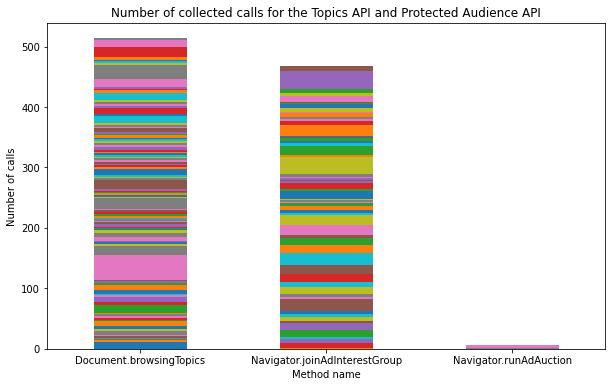

In [4]:
calls_df.groupby("description")["finalUrlFld"].value_counts().unstack().plot.bar(
    stacked = True,
    legend = False,
    title = "Number of collected calls for the Topics API and Protected Audience API",
    xlabel = "Method name",
    ylabel = "Number of calls",
    figsize = (10,6),
    rot = 0
)

In [5]:
for call_type, call_data in calls_df.groupby("description"):
    per_site = call_data.groupby("finalUrlFld")
    printMD(f"{len(call_data)} calls for `{call_type}`, on {len(per_site)} distinct sites ({len(per_site) / successfully_crawled_sites:.1%} of all successfully crawled sites):")
    display(per_site["sourceFld"].describe().sort_values(by="count", ascending=False))

514 calls for `Document.browsingTopics`, on 108 distinct sites (17.5% of all successfully crawled sites):

,count,unique,top,freq
finalUrlFld,,,,
elmundo.es,42,4,doubleclick.net,35
uol.com.br,24,3,uol.com.br,12
mailchimp.com,18,1,teads.tv,18
wikihow.com,16,3,rubiconproject.com,10
name.com,15,3,teads.tv,9
...,...,...,...,...
reg.ru,1,1,criteo.com,1
ieee.org,1,1,licdn.com,1
hp.com,1,1,licdn.com,1


468 calls for `Navigator.joinAdInterestGroup`, on 63 distinct sites (10.2% of all successfully crawled sites):

,count,unique,top,freq
finalUrlFld,,,,
wiley.com,30,1,doubleclick.net,30
newrelic.com,28,1,doubleclick.net,28
entrust.com,21,1,doubleclick.net,21
constantcontact.com,20,1,doubleclick.net,20
samsung.com,18,1,doubleclick.net,18
...,...,...,...,...
ancestry.com,2,1,doubleclick.net,2
reg.ru,2,1,criteo.com,2
adjust.com,2,1,doubleclick.net,2


7 calls for `Navigator.runAdAuction`, on 2 distinct sites (0.3% of all successfully crawled sites):

,count,unique,top,freq
finalUrlFld,,,,
yahoo.com,6,1,doubleclick.net,6
ameblo.jp,1,1,doubleclick.net,1


- `count`: total number of calls per site
- `unique`: number of unique callers per site
- `top`: caller with the most calls per site
- `freq`: number of calls for the `top` caller

Pilot crawl 2:
- 629 calls for `Document.browsingTopics`, on 98 distinct sites (13.41% of all successfully crawled sites)
- 141 calls for `Navigator.joinAdInterestGroup`, on 24 distinct sites (3.28% of all successfully crawled sites)
- 34 calls for `Navigator.runAdAuction`, on 4 distinct sites (0.55% of all successfully crawled sites)

### From which sources are the API calls coming?

In [6]:
for call_type, call_data in calls_df.groupby("description"):
    per_source = call_data.groupby("sourceFld")
    printMD(f"{len(call_data.groupby('finalUrlFld'))} websites with calls for `{call_type}`, from {len(per_source)} distinct callers:")
    display(per_source["finalUrlFld"].describe().sort_values(by="unique", ascending=False))

108 websites with calls for `Document.browsingTopics`, from 12 distinct callers:

,count,unique,top,freq
sourceFld,,,,
licdn.com,177,63,qualtrics.com,5
criteo.com,33,19,elpais.com,4
doubleclick.net,103,18,elmundo.es,35
rubiconproject.com,70,13,wikihow.com,10
taboola.com,28,12,healthline.com,3
teads.tv,68,7,mailchimp.com,18
creativecdn.com,6,6,soundcloud.com,1
top100.ru,9,3,rambler.ru,3
affec.tv,3,1,name.com,3


63 websites with calls for `Navigator.joinAdInterestGroup`, from 2 distinct callers:

,count,unique,top,freq
sourceFld,,,,
doubleclick.net,433,52,wiley.com,30
criteo.com,35,12,criteo.com,7


2 websites with calls for `Navigator.runAdAuction`, from 1 distinct callers:

,count,unique,top,freq
sourceFld,,,,
doubleclick.net,7,2,yahoo.com,6


- `count`: total number of calls per caller
- `unique`: number of unique websites the caller appears on
- `top`: website with the most calls from the caller
- `freq`: number of calls for the `top` website

### Analyzing `joinAdInterestGroup` calls

In [7]:
seconds_to_days = 1 / (60 * 60 * 24)
join_calls = calls_df[calls_df["description"] == "Navigator.joinAdInterestGroup"].copy()
join_calls["duration"] = join_calls["arguments"].apply(lambda arg: arg["1"] * seconds_to_days)

for subArg in ["owner", "name"]:
    join_calls[subArg] = join_calls["arguments"].apply(lambda arg: arg["0"].get(subArg))

for subArg in ["ads", "adComponents"]:
    join_calls[subArg] = join_calls["arguments"].apply(lambda arg: arg["0"].get(subArg, []))
    join_calls[f"{subArg}Len"] = join_calls[subArg].apply(lambda ads: len(ads))

display(join_calls.head(3))

,source,description,arguments,returnValue,accessType,frameURL,referrer,subpageIndex,initialUrl,finalUrl,initialUrlFld,finalUrlFld,sourceFld,duration,owner,name,ads,adsLen,adComponents,adComponentsLen
12,https://td.doubleclick.net/td/rul/993517329?ra...,Navigator.joinAdInterestGroup,"{'0': {'owner': 'https://td.doubleclick.net', ...",{},call,https://td.doubleclick.net/td/rul/993517329?ra...,https://www.digitalturbine.com/,-1,http://adcolony.com/,https://www.digitalturbine.com/,adcolony.com,digitalturbine.com,doubleclick.net,30.0,https://td.doubleclick.net,1j215464351,[{'renderUrl': 'https://tdsf.doubleclick.net/t...,12,[],0
13,https://td.doubleclick.net/td/rul/993517329?ra...,Navigator.joinAdInterestGroup,"{'0': {'owner': 'https://td.doubleclick.net', ...",{},call,https://td.doubleclick.net/td/rul/993517329?ra...,https://www.digitalturbine.com/,-1,http://adcolony.com/,https://www.digitalturbine.com/,adcolony.com,digitalturbine.com,doubleclick.net,30.0,https://td.doubleclick.net,1j391717425,[{'renderUrl': 'https://tdsf.doubleclick.net/t...,12,[],0
14,https://td.doubleclick.net/td/rul/993517329?ra...,Navigator.joinAdInterestGroup,"{'0': {'owner': 'https://td.doubleclick.net', ...",{},call,https://td.doubleclick.net/td/rul/993517329?ra...,https://www.digitalturbine.com/,-1,http://adcolony.com/,https://www.digitalturbine.com/,adcolony.com,digitalturbine.com,doubleclick.net,30.0,https://td.doubleclick.net,1j391717425,[{'renderUrl': 'https://tdsf.doubleclick.net/t...,12,[],0


#### Interest group owners

In [8]:
join_calls.groupby("owner")["finalUrlFld"].describe().sort_values(by="unique", ascending=False)

,count,unique,top,freq
owner,,,,
https://td.doubleclick.net,433,52,wiley.com,30
https://fledge.us.criteo.com,26,9,criteo.com,7
https://fledge.eu.criteo.com,9,3,alibaba.com,6


- `count`: total number of calls per owner
- `unique`: number of unique websites the owner appears on
- `top`: website with the most calls from the owner
- `freq`: number of calls for the `top` website

#### Durations/lifetime of interest groups
According to the [documentation](https://developer.chrome.com/docs/privacy-sandbox/protected-audience-api/interest-groups/#example-usage), the duration of interest groups is capped at 30 days (2592000 seconds).

,count,mean,std,min,25%,50%,75%,max
owner,,,,,,,,
https://fledge.eu.criteo.com,9.0,30.000000,0.000000,30.0,30.0,30.0,30.0,30.0
https://fledge.us.criteo.com,26.0,30.000000,0.000000,30.0,30.0,30.0,30.0,30.0
https://td.doubleclick.net,433.0,115.568129,167.816866,3.0,30.0,30.0,90.0,540.0


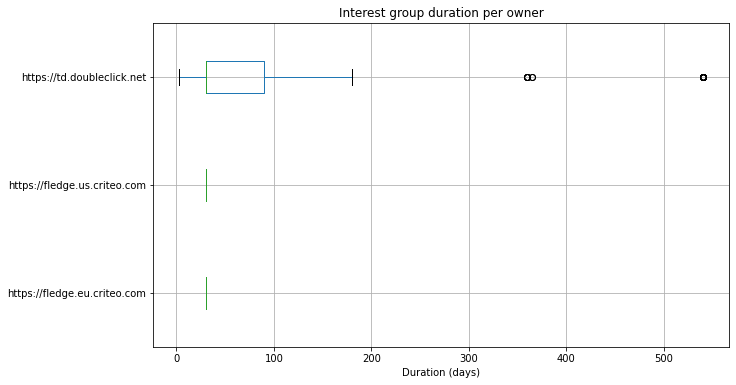

In [9]:
ax = join_calls.boxplot(
    column = "duration",
    by = "owner",
    vert = False,
    figsize = (10,6)
)
ax.get_figure().suptitle("")
ax.set_title("Interest group duration per owner")
ax.set_xlabel("Duration (days)")

join_calls.groupby("owner")["duration"].describe()

#### Number of ads per interest group

,count,mean,std,min,25%,50%,75%,max
owner,,,,,,,,
https://fledge.eu.criteo.com,9.0,1.000000,1.732051,0.0,0.0,0.0,1.00,4.0
https://fledge.us.criteo.com,26.0,1.038462,2.271225,0.0,0.0,0.0,0.75,7.0
https://td.doubleclick.net,433.0,34.503464,55.591271,1.0,5.0,10.0,35.00,240.0


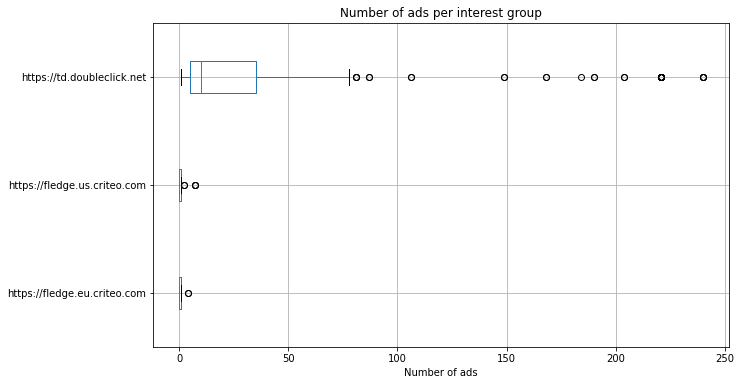

In [10]:
ax = join_calls.boxplot(
    column = "adsLen",
    by = "owner",
    vert = False,
    figsize = (10,6)
)
ax.get_figure().suptitle("")
ax.set_title("Number of ads per interest group")
ax.set_xlabel("Number of ads")

join_calls.groupby("owner")["adsLen"].describe()

#### Sites with the largest number of ads in a single interest group

In [27]:
for source, data in join_calls[["sourceFld", "finalUrlFld", "adsLen"]].groupby("sourceFld"):
    printMD("Interest groups with most ads for %s:" % source)
    display(data.groupby("finalUrlFld").max(numeric_only=True).sort_values("adsLen", ascending=False).head(5))

Interest groups with most ads for criteo.com:

,adsLen
finalUrlFld,
nike.com,7
alibaba.com,4
hostgator.com.br,2
aliexpress.com,1
netgear.com,1


Interest groups with most ads for doubleclick.net:

,adsLen
finalUrlFld,
upwork.com,240
newrelic.com,221
conviva.com,204
grammarly.com,190
hp.com,184


#### Some example `renderUrl`'s from the ads

In [54]:
txt = ""
for ad in join_calls[(join_calls["sourceFld"] == "criteo.com") & (join_calls["finalUrlFld"] == "nike.com")].iloc[0].ads:
    txt += f"- `{ad.get('renderURL')}`\n"
printMD(txt)

- `https://fledge.us.criteo.com/delivery/fledge?campaignId=398589&bannerId=11406645&width=${AD_WIDTH}&height=${AD_HEIGHT}`
- `https://fledge.us.criteo.com/delivery/fledge?campaignId=390628&bannerId=11382699&width=${AD_WIDTH}&height=${AD_HEIGHT}`
- `https://fledge.us.criteo.com/delivery/fledge?campaignId=398591&bannerId=11406651&width=${AD_WIDTH}&height=${AD_HEIGHT}`
- `https://fledge.us.criteo.com/delivery/fledge?campaignId=168485&bannerId=11099608&width=${AD_WIDTH}&height=${AD_HEIGHT}`
- `https://fledge.us.criteo.com/delivery/fledge?campaignId=398590&bannerId=11406648&width=${AD_WIDTH}&height=${AD_HEIGHT}`
- `https://fledge.us.criteo.com/delivery/fledge?campaignId=277254&bannerId=11016018&width=${AD_WIDTH}&height=${AD_HEIGHT}`
- `https://fledge.us.criteo.com/delivery/fledge?campaignId=168209&bannerId=11099606&width=${AD_WIDTH}&height=${AD_HEIGHT}`


In [62]:
txt = ""
for ad in join_calls[(join_calls["sourceFld"] == "doubleclick.net") & (join_calls["finalUrlFld"] == "upwork.com")].iloc[0].ads:
    txt += f"- `{ad.get('renderUrl')}`\n"
    if len(txt) > 1600:
        txt += "- ..."
        break
printMD(txt)

- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660478723091&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660478723094&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660478723097&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660478723100&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660478723103&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660537414646&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660537414649&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660537414652&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660537414655&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660537414658&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- `https://tdsf.doubleclick.net/td/adfetch/gda?adg_id=152324381249&cr_id=660599007020&cv_id=2&format=${AD_WIDTH}x${AD_HEIGHT}&rds=${RENDER_DATA}`
- ...

#### Number of ad components per interest group

,count,mean,std,min,25%,50%,75%,max
owner,,,,,,,,
https://fledge.eu.criteo.com,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://fledge.us.criteo.com,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://td.doubleclick.net,433.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


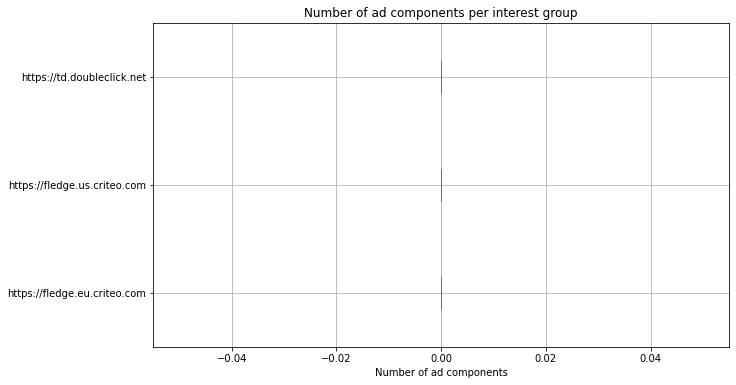

In [12]:
ax = join_calls.boxplot(
    column = "adComponentsLen",
    by = "owner",
    vert = False,
    figsize = (10,6)
)
ax.get_figure().suptitle("")
ax.set_title("Number of ad components per interest group")
ax.set_xlabel("Number of ad components")

join_calls.groupby("owner")["adComponentsLen"].describe()

### Analyzing `runAdAuction` calls

In [13]:
auction_calls = calls_df[calls_df["description"] == "Navigator.runAdAuction"].copy()
auction_calls["seller"] = auction_calls["arguments"].apply(lambda arg: arg["0"].get("seller"))

display(auction_calls.head(3))

,source,description,arguments,returnValue,accessType,frameURL,referrer,subpageIndex,initialUrl,finalUrl,initialUrlFld,finalUrlFld,sourceFld,seller
875,https://securepubads.g.doubleclick.net/pagead/...,Navigator.runAdAuction,{'0': {'seller': 'https://securepubads.g.doubl...,{},call,https://ameblo.jp/chunta-2011/,,1,http://ameblo.jp/,https://ameblo.jp/,ameblo.jp,ameblo.jp,doubleclick.net,https://securepubads.g.doubleclick.net
979,https://securepubads.g.doubleclick.net/pagead/...,Navigator.runAdAuction,{'0': {'seller': 'https://securepubads.g.doubl...,{},call,https://www.yahoo.com/,,-1,http://yahoo.net/,https://www.yahoo.com/,yahoo.net,yahoo.com,doubleclick.net,https://securepubads.g.doubleclick.net
980,https://securepubads.g.doubleclick.net/pagead/...,Navigator.runAdAuction,{'0': {'seller': 'https://securepubads.g.doubl...,{},call,https://www.yahoo.com/,,-1,http://yahoo.net/,https://www.yahoo.com/,yahoo.net,yahoo.com,doubleclick.net,https://securepubads.g.doubleclick.net


#### Who are the auction sellers?

In [14]:
auction_calls.groupby("seller")["finalUrlFld"].describe().sort_values(by="unique", ascending=False)

,count,unique,top,freq
seller,,,,
https://securepubads.g.doubleclick.net,7,2,yahoo.com,6


- `count`: total number of calls per seller
- `unique`: number of unique websites the seller appears on
- `top`: website with the most calls from the seller
- `freq`: number of calls for the `top` website

### Did the calls come from crawled subpages?

In [15]:
subpage_calls = calls_df.groupby("description")["subpageIndex"].value_counts().unstack().fillna(0)
display(subpage_calls)

subpageIndex,-1,0,1
description,,,
Document.browsingTopics,290.0,134.0,90.0
Navigator.joinAdInterestGroup,154.0,183.0,131.0
Navigator.runAdAuction,3.0,0.0,4.0


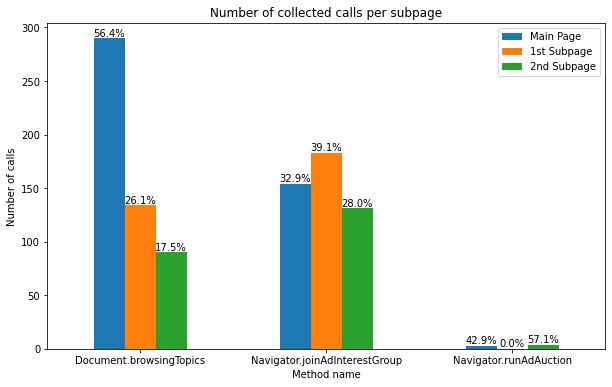

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
subpage_calls.plot.bar(
    title = "Number of collected calls per subpage",
    xlabel = "Method name",
    ylabel = "Number of calls",
    ax = ax,
    rot = 0
)
ax.legend(["Main Page", "1st Subpage", "2nd Subpage"])
total = subpage_calls.sum(axis=1)
for container, subpage in zip(ax.containers, subpage_calls):
    ax.bar_label(container, labels=(subpage_calls[subpage] / total * 100).round(1).astype(str) + "%")

In [17]:
first_subpage_calls = calls_df.groupby(["description", "finalUrlFld"])["subpageIndex"].min().reset_index(level="finalUrlFld")["subpageIndex"] \
    .groupby("description").value_counts().unstack().fillna(0)
display(first_subpage_calls)

subpageIndex,-1,0,1
description,,,
Document.browsingTopics,100.0,5.0,3.0
Navigator.joinAdInterestGroup,45.0,16.0,2.0
Navigator.runAdAuction,1.0,0.0,1.0


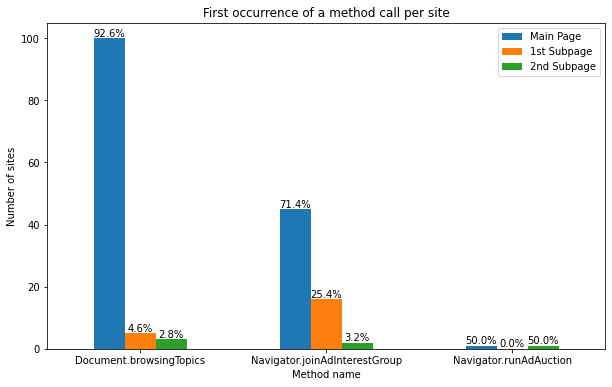

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
first_subpage_calls.plot.bar(
    title = "First occurrence of a method call per site",
    xlabel = "Method name",
    ylabel = "Number of sites",
    ax = ax,
    rot = 0,
)
ax.legend(["Main Page", "1st Subpage", "2nd Subpage"])
total = first_subpage_calls.sum(axis=1)
for container, subpage in zip(ax.containers, subpage_calls):
    ax.bar_label(container, labels=(first_subpage_calls[subpage] / total * 100).round(1).astype(str) + "%")